# Credit Scoring with Snowpark & LocalStack

In this notebook, we will explore how you can use LocalStack's Snowflake emulator extension, to develop and test your Snowflake data pipelines entirely on your local machine! In this notebook, we will showcase how you can use LocalStack's Snowflake with Snowpark for Python and your favorite Python libraries for data analysis!

## Step 1: Start LocalStack

The essential prerequisites for running this notebook include:

1. LocalStack CLI with a `LOCALSTACK_AUTH_TOKEN`
2. LocalStack Snowflake
3. Snowpark with other Python libraries

Start your LocalStack container in your preferred terminal/shell.

In [1]:
!localstack status

┌─────────────────┬───────────────────────────────────────────────────────┐
│ Runtime version │ 3.1.1.dev                                             │
│ Docker image    │ tag: latest, id: e54cdb22ef6d, 📆 2024-02-01T21:12:55 │
│ Runtime status  │ ✔ running (name: "localstack-main", IP: 172.17.0.2)   │
└─────────────────┴───────────────────────────────────────────────────────┘
⠙ Querying Docker status


## Step 2: Install Python libraries

The following libraries are needed to run this sample notebook.

In [ ]:
pip install scikit-plot

In [ ]:
pip install pyarrow==6.0.0

In [ ]:
pip install seaborn

In [ ]:
pip install matplotlib

In [ ]:
pip install pandas

## Step 3: Configure LocalStack's Snowflake

The next step is to configure LocalStack's Snowflake. LocalStack Snowflake emulator runs on `snowflake.localhost.localstack.cloud`. You can use the Snowpark to connect to the locally running Snowflake server.

In [2]:
from snowflake.snowpark import *
from snowflake.snowpark import version
from snowflake.snowpark.functions import *

connection_parameters = {
    "user": "test",
    "password": "test",
    "account": "test",
    "warehouse": "test",
    "host": "snowflake.localhost.localstack.cloud",
}

session = Session.builder.configs(connection_parameters).create()

In the above configuration, you can set `user`, `password`, `account`, and `warehouse` as `test` to avoid passing any production values. You can now run Snowflake SQL queries on your local machine.

In [3]:
session.sql("create or replace database credit_bank").collect()
session.sql("use schema credit_bank.public").collect()
print(session.sql("select current_warehouse(), current_database(), current_schema(), current_user(), current_role()").collect())

[Row(?COLUMN?='TEST', CURRENT_DATABASE='CREDIT_BANK', CURRENT_SCHEMA='public', ?COLUMN?='TEST', GET_CURRENT_ROLE='PUBLIC')]


## Step 4: Create the tables

You can now create two tables associated with this demo:

- `CREDIT_FILES`: This table contains the credit on files along with the credit standing whether the loan is being repaid or if there are actual issues with reimbursing the credit.
- `CREDIT_REQUESTS`: This table contains the new credit requests that the bank needs to provide approval on.

In [4]:
import pandas as pd
credit_files = pd.read_csv('credit_files.csv')
session.write_pandas(credit_files,"CREDIT_FILES",auto_create_table='True')

In [5]:
credit_df = session.table("CREDIT_FILES")
credit_df.schema

StructType([StructField('CREDIT_REQUEST_ID', LongType(), nullable=True), StructField('CREDIT_AMOUNT', LongType(), nullable=True), StructField('CREDIT_DURATION', LongType(), nullable=True), StructField('PURPOSE', StringType(), nullable=True), StructField('INSTALLMENT_COMMITMENT', LongType(), nullable=True), StructField('OTHER_PARTIES', StringType(), nullable=True), StructField('CREDIT_STANDING', StringType(), nullable=True), StructField('CREDIT_SCORE', LongType(), nullable=True), StructField('CHECKING_BALANCE', LongType(), nullable=True), StructField('SAVINGS_BALANCE', LongType(), nullable=True), StructField('EXISTING_CREDITS', LongType(), nullable=True), StructField('ASSETS', StringType(), nullable=True), StructField('HOUSING', StringType(), nullable=True), StructField('QUALIFICATION', StringType(), nullable=True), StructField('JOB_HISTORY', LongType(), nullable=True), StructField('AGE', LongType(), nullable=True), StructField('SEX', StringType(), nullable=True), StructField('MARITAL_S

In [6]:
credit_df.toPandas().head()

,CREDIT_REQUEST_ID,CREDIT_AMOUNT,CREDIT_DURATION,PURPOSE,INSTALLMENT_COMMITMENT,OTHER_PARTIES,CREDIT_STANDING,CREDIT_SCORE,CHECKING_BALANCE,SAVINGS_BALANCE,...,ASSETS,HOUSING,QUALIFICATION,JOB_HISTORY,AGE,SEX,MARITAL_STATUS,NUM_DEPENDENTS,RESIDENCE_SINCE,OTHER_PAYMENT_PLANS
0,147,8600,6,Vehicle,1,None,good,466,-728.12,17.0,...,None,own,skilled,15,39,F,Married,1,4,none
1,248,12040,6,Vehicle,4,None,good,202,0.00,2443.0,...,None,rent,skilled,1,35,M,Single,1,1,bank
2,112,3920,15,Tuition,4,None,good,736,4696.00,143.0,...,Investments,rent,skilled,1,23,F,Married,1,4,none
3,222,12000,12,Tuition,4,None,good,732,-25.35,0.0,...,Investments,rent,skilled,3,23,F,Married,1,4,bank
4,162,10550,18,Vehicle,4,None,good,507,0.00,510.0,...,Investments,own,skilled,1,30,F,Married,1,1,none


In [7]:
credit_df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CREDIT_REQUEST_ID       56 non-null     int64  
 1   CREDIT_AMOUNT           56 non-null     int64  
 2   CREDIT_DURATION         56 non-null     int64  
 3   PURPOSE                 56 non-null     object 
 4   INSTALLMENT_COMMITMENT  56 non-null     int64  
 5   OTHER_PARTIES           56 non-null     object 
 6   CREDIT_STANDING         56 non-null     object 
 7   CREDIT_SCORE            56 non-null     int64  
 8   CHECKING_BALANCE        56 non-null     float64
 9   SAVINGS_BALANCE         56 non-null     float64
 10  EXISTING_CREDITS        56 non-null     int64  
 11  ASSETS                  56 non-null     object 
 12  HOUSING                 56 non-null     object 
 13  QUALIFICATION           56 non-null     object 
 14  JOB_HISTORY             56 non-null     int6

In [8]:
credit_requests = pd.read_csv('credit_request.csv')
session.write_pandas(credit_requests,"CREDIT_REQUESTS",auto_create_table='True')

In [9]:
credit_req_df = session.table("CREDIT_REQUESTS")
credit_req_df.schema

StructType([StructField('CREDIT_REQUEST_ID', LongType(), nullable=True), StructField('CREDIT_AMOUNT', LongType(), nullable=True), StructField('CREDIT_DURATION', LongType(), nullable=True), StructField('PURPOSE', StringType(), nullable=True), StructField('INSTALLMENT_COMMITMENT', LongType(), nullable=True), StructField('OTHER_PARTIES', StringType(), nullable=True), StructField('CREDIT_SCORE', LongType(), nullable=True), StructField('CHECKING_BALANCE', LongType(), nullable=True), StructField('SAVINGS_BALANCE', LongType(), nullable=True), StructField('EXISTING_CREDITS', LongType(), nullable=True), StructField('ASSETS', StringType(), nullable=True), StructField('HOUSING', StringType(), nullable=True), StructField('QUALIFICATION', StringType(), nullable=True), StructField('JOB_HISTORY', LongType(), nullable=True), StructField('AGE', LongType(), nullable=True), StructField('SEX', StringType(), nullable=True), StructField('MARITAL_STATUS', StringType(), nullable=True), StructField('NUM_DEPEND

In [10]:
credit_req_df.toPandas().head()

,CREDIT_REQUEST_ID,CREDIT_AMOUNT,CREDIT_DURATION,PURPOSE,INSTALLMENT_COMMITMENT,OTHER_PARTIES,CREDIT_SCORE,CHECKING_BALANCE,SAVINGS_BALANCE,EXISTING_CREDITS,ASSETS,HOUSING,QUALIFICATION,JOB_HISTORY,AGE,SEX,MARITAL_STATUS,NUM_DEPENDENTS,RESIDENCE_SINCE,OTHER_PAYMENT_PLANS
0,182,44550,36,Business,2,None,656,259.00,628.0,2,Home,own,highly skilled,1,30,M,Divorced,1,2,stores
1,188,11750,16,Vehicle,2,None,549,1892.00,723.0,3,Vehicle,free,unemployed,0,68,M,Single,1,3,none
2,122,38680,24,Vehicle,4,None,356,0.00,586.0,2,Vehicle,rent,highly skilled,7,41,F,Married,1,2,none
3,245,34470,12,Tuition,4,None,749,0.00,8102.0,1,Home,own,unskilled,1,35,F,Married,2,3,none
4,447,18420,36,Vehicle,4,None,672,-463.77,428.0,1,Vehicle,own,skilled,1,34,F,Married,1,4,none


In [11]:
credit_req_df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CREDIT_REQUEST_ID       56 non-null     int64  
 1   CREDIT_AMOUNT           56 non-null     int64  
 2   CREDIT_DURATION         56 non-null     int64  
 3   PURPOSE                 56 non-null     object 
 4   INSTALLMENT_COMMITMENT  56 non-null     int64  
 5   OTHER_PARTIES           56 non-null     object 
 6   CREDIT_SCORE            56 non-null     int64  
 7   CHECKING_BALANCE        56 non-null     float64
 8   SAVINGS_BALANCE         56 non-null     float64
 9   EXISTING_CREDITS        56 non-null     int64  
 10  ASSETS                  56 non-null     object 
 11  HOUSING                 56 non-null     object 
 12  QUALIFICATION           56 non-null     object 
 13  JOB_HISTORY             56 non-null     int64  
 14  AGE                     56 non-null     int6

## Step 4: Perform some visualization

Now you can visualize the numeric features and categorical features.

array([[<Axes: title={'center': 'CREDIT_REQUEST_ID'}>,
        <Axes: title={'center': 'CREDIT_AMOUNT'}>,
        <Axes: title={'center': 'CREDIT_DURATION'}>],
       [<Axes: title={'center': 'INSTALLMENT_COMMITMENT'}>,
        <Axes: title={'center': 'CREDIT_SCORE'}>,
        <Axes: title={'center': 'CHECKING_BALANCE'}>],
       [<Axes: title={'center': 'SAVINGS_BALANCE'}>,
        <Axes: title={'center': 'EXISTING_CREDITS'}>,
        <Axes: title={'center': 'JOB_HISTORY'}>],
       [<Axes: title={'center': 'AGE'}>,
        <Axes: title={'center': 'NUM_DEPENDENTS'}>,
        <Axes: title={'center': 'RESIDENCE_SINCE'}>]], dtype=object)

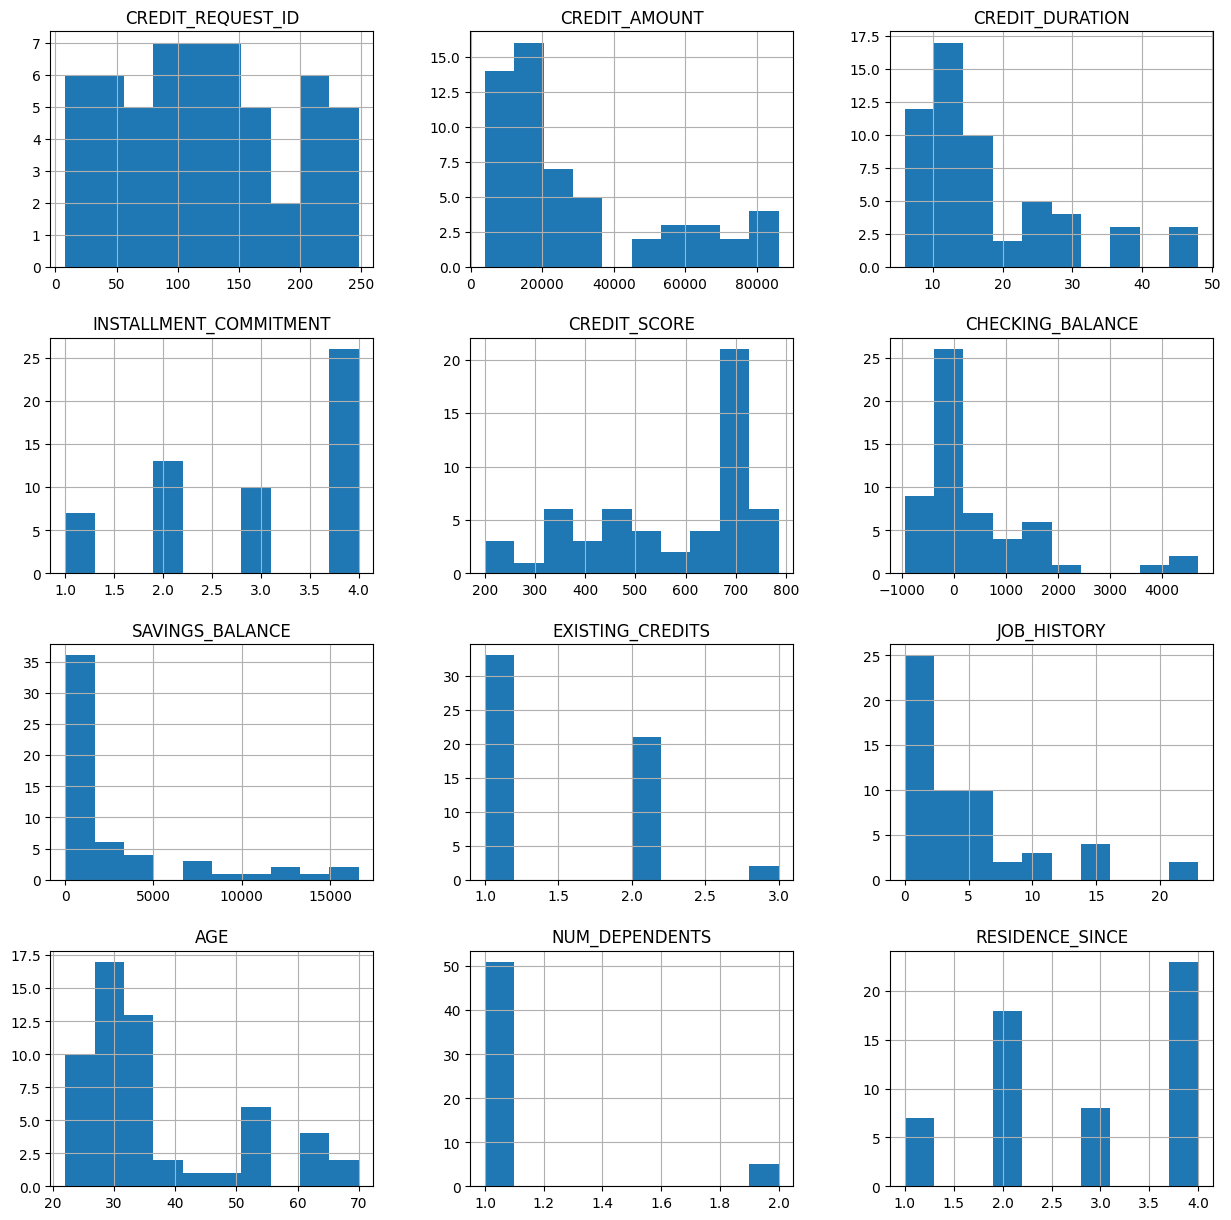

In [12]:
# Numeric
credit_df.toPandas().hist(figsize=(15,15))

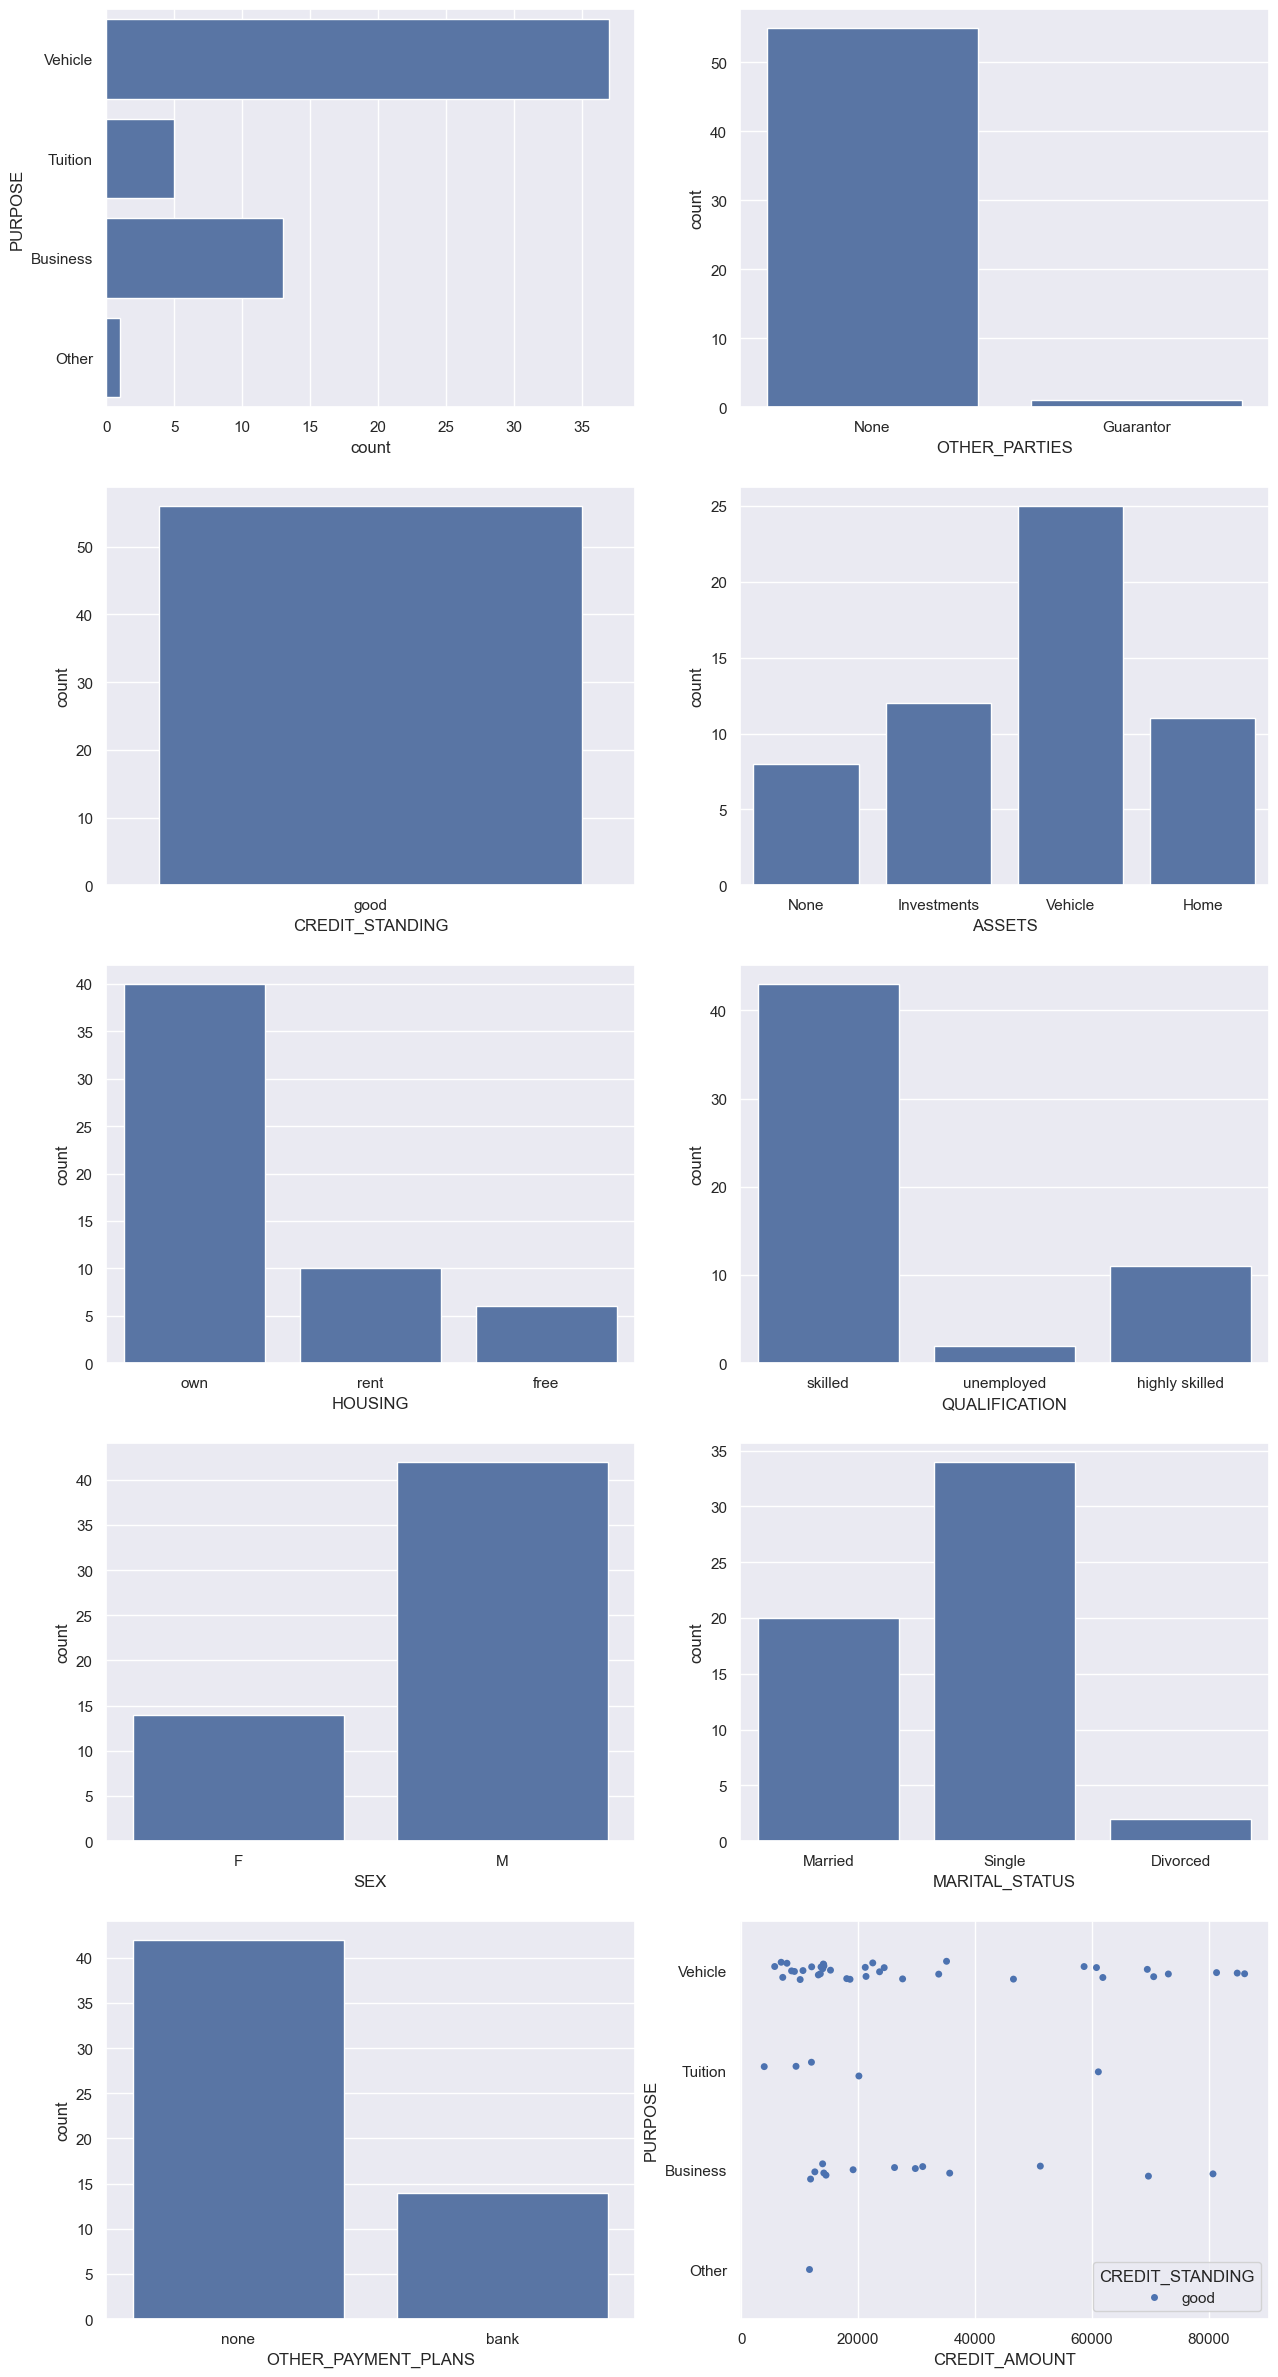

In [13]:
# Categorical
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")


fig, axs = plt.subplots(5, 2, figsize=(15, 30))
df = credit_df.toPandas()
sns.countplot(data=df, y="PURPOSE", ax=axs[0,0])
sns.countplot(data=df, x="OTHER_PARTIES", ax=axs[0,1])
sns.countplot(data=df, x="CREDIT_STANDING", ax=axs[1,0])
sns.countplot(data=df, x="ASSETS", ax=axs[1,1])
sns.countplot(data=df, x="HOUSING", ax=axs[2,0])
sns.countplot(data=df, x="QUALIFICATION", ax=axs[2,1])
sns.countplot(data=df, x="SEX", ax=axs[3,0])
sns.countplot(data=df, x="MARITAL_STATUS", ax=axs[3,1])
sns.countplot(data=df, x="OTHER_PAYMENT_PLANS", ax=axs[4,0])
sns.stripplot(y="PURPOSE", x="CREDIT_AMOUNT", data=df, hue='CREDIT_STANDING', jitter=True, ax=axs[4,1])
plt.show()

You can now perform further experimentations with LocalStack's Snowflake emulation. For example, you can use the Snowpark API to run queries to get various insights, such as determining the range of loans per different category.

To share any feedback or bug report, you can share it on this [thread](https://discuss.localstack.cloud/t/introducing-the-localstack-snowflake-extension-experimental/665/6).